In [1]:
import glob
import seaborn
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define unit conversion and area weights

In [2]:
def unit_conv(ds):
    if var in ['TSA','TSKIN','TREFHT','TSMX','TSMN']:
        ds=ds-273.15
    return ds

In [3]:
ds_temp = xr.open_dataset('/glade/campaign/cgd/tss/czarakas/'+
                           'COUP0000_PI_SOM'+
                           '/atm/hist/'+
                           'COUP0000_PI_SOM.cam.h1.0049-10.nc')
weights =ds_temp.gw/ds_temp.gw.mean(dim='lat')

ds_temp2 = xr.open_dataset('/glade/campaign/cgd/tss/czarakas/'+
                           'COUP0000_PI_SOM'+
                           '/lnd/hist/'+
                           'COUP0000_PI_SOM.clm2.h0.0049-02-01-00000.nc')

landarea=(ds_temp2.area*ds_temp2.landfrac)
landweights=landarea/landarea.mean(dim=['lat','lon'])

In [4]:
pct_nonglac=100-ds_temp2.PCT_LANDUNIT.mean(dim='time')[3,:,:]

In [5]:
landarea_nonglac=landarea*pct_nonglac/100
landweights_nonglac=landarea_nonglac/landarea_nonglac.mean(dim=['lat','lon'])

In [6]:
landweights_nonglac_atmvar=landweights_nonglac.reindex_like(weights, method='nearest',
                                                            tolerance=0.05)

In [7]:
def get_landweights(minlat=-100, maxlat=100, atm_var=True, absval=False):
    if absval:
        landarea_nonglac_subset=landarea_nonglac.where(np.abs(landarea_nonglac.lat)>=minlat)
        landarea_nonglac_subset=landarea_nonglac_subset.where(np.abs(landarea_nonglac_subset.lat)<=maxlat)
    else:
        landarea_nonglac_subset=landarea_nonglac.where(landarea_nonglac.lat>=minlat)
        landarea_nonglac_subset=landarea_nonglac_subset.where(landarea_nonglac_subset.lat<=maxlat)
    
    landweights_nonglac=landarea_nonglac_subset/landarea_nonglac_subset.mean(dim=['lat','lon'])
    
    if atm_var:
        landweights_nonglac=landweights_nonglac.reindex_like(weights, method='nearest',tolerance=0.05)
    
    return landweights_nonglac

# Read in data

In [69]:
# All the param experiments

keys=['0001','0003','0004','0005',
      '0006','0007','0008','0009','0010',
      '0011','0012','0013','0014','0015',
      '0016','0017','0018','0019','0020',
      '0021','0022','0023','0024','0025',
     '0026','0027','0028','0029','0030',
     '0031','0032','0033','0034','0035',
     '0036']

In [9]:
# Only plant parameters
keys=['0001','0013','0014','0019','0020',
      '0021','0022','0023','0024','0025',
     '0026','0027','0028','0029','0030',
     '0031','0032','0033','0034']

In [70]:
paramkey = pd.read_csv('/glade/u/home/czarakas/coupled_PPE/code/set_up_ensemble/CLM5PPE_coupledPPE_crosswalk.csv')

# Atmosphere

In [71]:
var='TREFHT'
var_domain='atm'

In [72]:
ensemble_atm = []

if var_domain=='atm':
    basecase=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/COUP0000_PI_SOM/atm/proc/tseries/COUP0000_PI_SOM.cam.h1.timeseries.'+var+'.nc')
    for key in keys:
        #print(key)
        fpath=('/glade/campaign/cgd/tss/czarakas/COUP'+
                               key+'_PI_SOM_v02/atm/proc/tseries/'+
                               'COUP'+key+'_PI_SOM_v02.cam.h1.timeseries.'+var+'.nc')
        if np.size(glob.glob(fpath))>0:
            ds = xr.open_mfdataset(fpath)
        else:
            print("no "+fpath)
            ds = None
        ensemble_atm.append(ds)
elif var_domain=='lnd':
    basecase=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/COUP0000_PI_SOM/lnd/proc/tseries/COUP0000_PI_SOM.clm2.h0.timeseries.'+var+'.nc')
    for key in keys:
        #print(key)
        fpath=('/glade/campaign/cgd/tss/czarakas/COUP'+
                               key+'_PI_SOM_v02/lnd/proc/tseries/'+
                               'COUP'+key+'_PI_SOM_v02.clm2.h0.timeseries.'+var+'.nc')
        if np.size(glob.glob(fpath))>0:
            ds = xr.open_mfdataset(fpath)
        else:
            print("no "+fpath)
            ds = None
        ensemble_atm.append(ds)

In [73]:
def get_basecase_value(weights):
    ds = basecase
    avg_val = ((ds[var]*weights).mean(dim=['lat','lon']))[40*12:]
    avg_val=avg_val.groupby('time.year').mean(dim='time')
    avg_val_global=avg_val.mean(dim='year').values.item()
    
    return avg_val_global

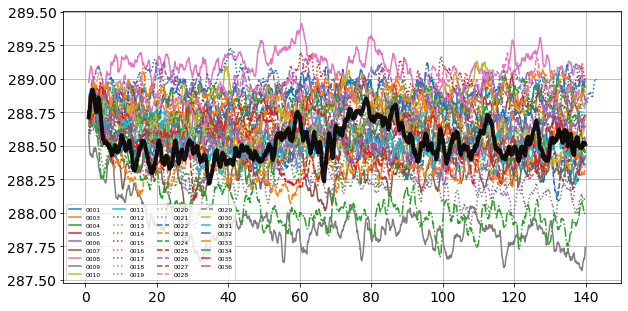

In [74]:
plt.figure(figsize=(10,5))
for i,key in enumerate(keys):
    if i>27:
        linestyle='dashdot'
    elif i>19:
        linestyle='--'
    elif i>9:
        linestyle=':'
    else:
        linestyle='-'
    ds=ensemble_atm[i]
    if ds is not None:
        years=np.arange(0,np.size(ds.time))/12
        plt.plot(years,(ds[var]*weights).mean(dim=['lat','lon']).rolling(time=12).mean(),
             linestyle=linestyle,
            label=key)
years=np.arange(0,np.size(basecase.time))/12
plt.plot(years,(basecase[var]*weights).mean(dim=['lat','lon']).rolling(time=12).mean(),
         '-k',linewidth=4,alpha=0.9)
plt.legend(ncol=4,fontsize=6)
plt.grid()

In [75]:
global_atm_coupled=[]

if var_domain=='atm':   
    for ds in ensemble_atm:
        if np.size(ds[var].time)/12>100:
            avg_val = ((ds[var]*weights).mean(dim=['lat','lon']))[40*12:]
            avg_val=avg_val.groupby('time.year').mean(dim='time')
            avg_val=avg_val.mean(dim='year').values.item()
            global_atm_coupled.append(avg_val)
        else:
            global_atm_coupled.append(None)
elif var_domain=='lnd':
    for ds in ensemble_atm:
        if np.size(ds[var].time)/12>100:
            avg_val = ((ds[var]*landweights_nonglac_atmvar).mean(dim=['lat','lon']))[40*12:]
            avg_val=avg_val.groupby('time.year').mean(dim='time')
            avg_val=avg_val.mean(dim='year').values.item()
            global_atm_coupled.append(avg_val)
        else:
            global_atm_coupled.append(None)

avg_val_global=get_basecase_value(weights=weights)

In [76]:
global_atm_landarea_coupled=[]
for ds in ensemble_atm:
    if np.size(ds[var].time)/12>100:
        avg_val = ((ds[var]*landweights_nonglac_atmvar).mean(dim=['lat','lon']))[40*12:]
        avg_val=avg_val.groupby('time.year').mean(dim='time')
        avg_val=avg_val.mean(dim='year').values.item()
        global_atm_landarea_coupled.append(avg_val)
    else:
        global_atm_landarea_coupled.append(None)
        
avg_val_land=get_basecase_value(weights=landweights_nonglac_atmvar)

In [77]:
landweight_subset=get_landweights(minlat=-30, maxlat=30, atm_var=True)
landarea_coupled_tropics=[]
for ds in ensemble_atm:
    if np.size(ds[var].time)/12>100:
        avg_val = ((ds[var]*landweight_subset).mean(dim=['lat','lon']))[40*12:]
        avg_val=avg_val.groupby('time.year').mean(dim='time')
        avg_val=avg_val.mean(dim='year').values.item()
        landarea_coupled_tropics.append(avg_val)
    else:
        landarea_coupled_tropics.append(None)
        
avg_val_tropics=get_basecase_value(weights=landweight_subset)

In [78]:
landweight_subset=get_landweights(minlat=30, maxlat=60, absval=True, atm_var=True)
landarea_coupled_NHmidlat=[]
for ds in ensemble_atm:
    if np.size(ds[var].time)/12>100:
        avg_val = ((ds[var]*landweight_subset).mean(dim=['lat','lon']))[40*12:]
        avg_val=avg_val.groupby('time.year').mean(dim='time')
        avg_val=avg_val.mean(dim='year').values.item()
        landarea_coupled_NHmidlat.append(avg_val)
    else:
        landarea_coupled_NHmidlat.append(None)
        
avg_val_midlat=get_basecase_value(weights=landweight_subset)

In [79]:
landweight_subset=get_landweights(minlat=60, maxlat=90, absval=True, atm_var=True)
landarea_coupled_NHhighlat=[]
for ds in ensemble_atm:
    if np.size(ds[var].time)/12>100:
        avg_val = ((ds[var]*landweight_subset).mean(dim=['lat','lon']))[40*12:]
        avg_val=avg_val.groupby('time.year').mean(dim='time')
        avg_val=avg_val.mean(dim='year').values.item()
        landarea_coupled_NHhighlat.append(avg_val)
    else:
        landarea_coupled_NHhighlat.append(None)
        
avg_val_highlat=get_basecase_value(weights=landweight_subset)

In [80]:
global_atm_coupled.append(avg_val_global)
global_atm_landarea_coupled.append(avg_val_land)
landarea_coupled_tropics.append(avg_val_tropics)
landarea_coupled_NHmidlat.append(avg_val_midlat)
landarea_coupled_NHhighlat.append(avg_val_highlat)

In [47]:
plt.rcParams.update({'font.size': 14})

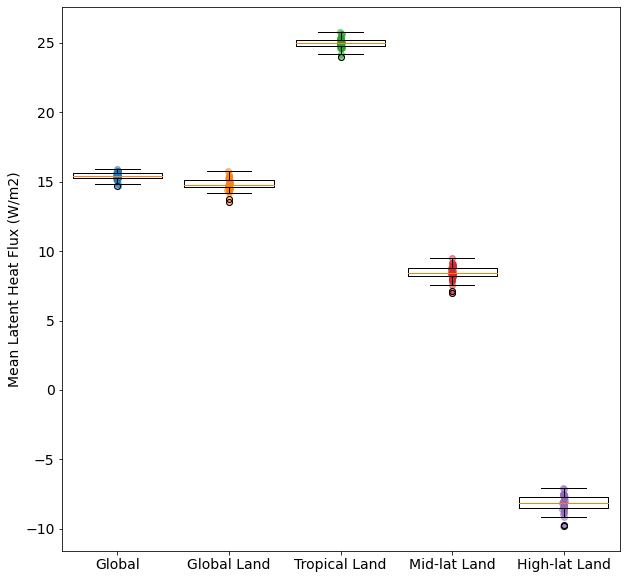

In [48]:
if var_domain=='atm':
    data_to_plot=[np.array(global_atm_coupled)-273.15, 
              np.array(global_atm_landarea_coupled)-273.15, 
              np.array(landarea_coupled_tropics)-273.15,
             np.array(landarea_coupled_NHmidlat)-273.15,
             np.array(landarea_coupled_NHhighlat)-273.15]
    labels=['Global','Global Land','Tropical Land',
                                 'Mid-lat Land','High-lat Land']
else:
    data_to_plot=[np.array(global_atm_landarea_coupled),#-273.15, *86400*365
              np.array(landarea_coupled_tropics),#-273.15,*86400*365
             np.array(landarea_coupled_NHmidlat),#-273.15,*86400*365
             np.array(landarea_coupled_NHhighlat)]#-273.15]*86400*365
    labels=['Global Land','Tropical Land',
                                 'Mid-lat Land','High-lat Land']

plt.figure(figsize=(10,10))
plt.boxplot(data_to_plot, labels=labels,
           widths=0.8)
for i, data in enumerate(data_to_plot):
    plt.scatter(np.random.normal(i+1, 0.005, np.size(data)), 
            data, alpha=0.5)

#plt.ylabel('Mean Temperature (Celsius)')
plt.ylabel('Mean Latent Heat Flux (W/m2)')
plt.savefig('BoxPlots_Global'+var+'.png')

In [49]:
np.shape(data_to_plot[1])

(38,)

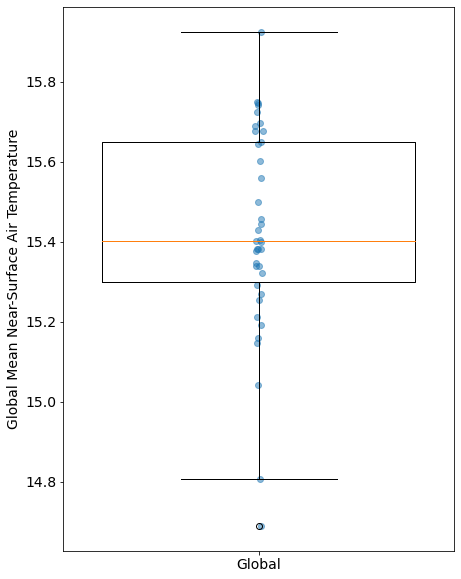

In [50]:
if var_domain=='atm':
    data_to_plot=[np.array(global_atm_coupled)-273.15]
    labels=['Global']

plt.figure(figsize=(7,10))
plt.boxplot(data_to_plot, labels=labels,
           widths=0.8)
for i, data in enumerate(data_to_plot):
    plt.scatter(np.random.normal(i+1, 0.005, np.size(data)), 
            data, alpha=0.5)

#plt.ylabel('Mean Temperature (Celsius)')
plt.ylabel('Global Mean Near-Surface Air Temperature')
plt.savefig('BoxPlots_Global'+var+'.png')

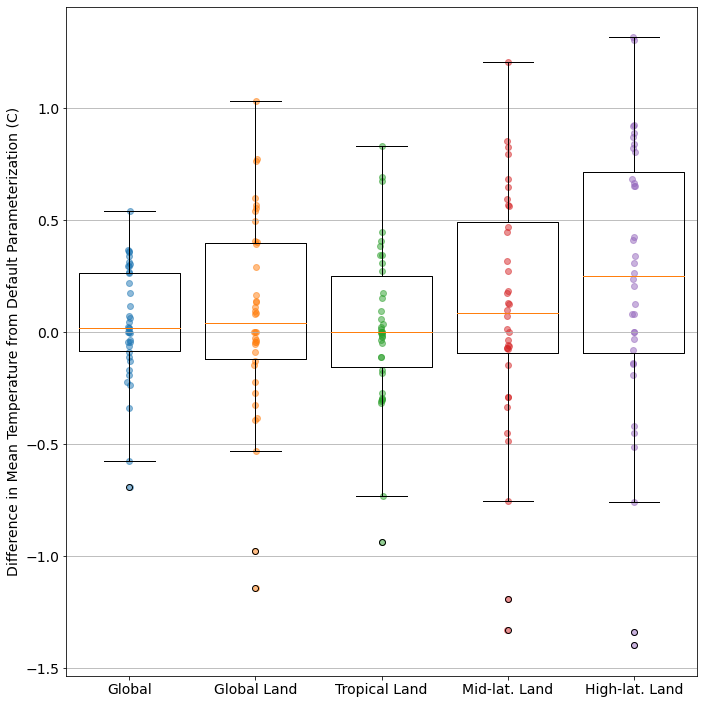

In [55]:
plt.rcParams.update({'font.size': 14})
if var_domain=='atm':
    data_to_plot=[np.array(global_atm_coupled)-avg_val_global, 
                  np.array(global_atm_landarea_coupled)-avg_val_land, 
                  np.array(landarea_coupled_tropics)-avg_val_tropics,
                 np.array(landarea_coupled_NHmidlat)-avg_val_midlat,
                 np.array(landarea_coupled_NHhighlat)-avg_val_highlat]
else:
    data_to_plot=[np.array(global_atm_landarea_coupled)-avg_val_land, #*86400*365-avg_val_land*86400*365, 
                  np.array(landarea_coupled_tropics)-avg_val_tropics,#*86400*365,
                 np.array(landarea_coupled_NHmidlat)-avg_val_midlat,#*86400*365,
                 np.array(landarea_coupled_NHhighlat)-avg_val_highlat]#*86400*365]
    
labels=['Global', 'Global Land','Tropical Land','Mid-lat. Land','High-lat. Land']

plt.figure(figsize=(10,10))
#plt.plot([0,6],[0,0],'-k', alpha=0.3)
boxes=plt.boxplot(data_to_plot, labels=labels,
           widths=0.8)#, patch_artist=True)
#plt.setp(boxes['boxes'], facecolor='white')

for i, data in enumerate(data_to_plot):
    plt.scatter(np.random.normal(i+1, 0.005, np.size(data)), 
            data, alpha=0.5)

if var_domain=='atm':
    plt.xlim([0.5, 5.5])
else:
    plt.xlim([0.5, 4.5])
    
plt.grid(axis='y')
plt.ylabel('Difference in Mean Temperature from Default Parameterization (C)')

plt.tight_layout()
#plt.ylabel('Difference in Mean Temperature from Default Parameterization (Celsius)')#Latent Heat Flux from Default Parameterization (W/m2)')
plt.savefig('BoxPlots_Global'+var+'_DiffFromDefault.png')

In [52]:
global
['0009']
['0008']

global land
['0009']
['0008']

tropical
['0034']
['0026']

high lat
['0034']
['0028']

SyntaxError: invalid syntax (<ipython-input-52-51a4918643f9>, line 1)

In [ ]:
[np.array(global_atm_coupled)-avg_val_global, 
                  np.array(global_atm_landarea_coupled)-avg_val_land, 
                  np.array(landarea_coupled_tropics)-avg_val_tropics,
                 np.array(landarea_coupled_NHmidlat)-avg_val_midlat,
                 np.array(landarea_coupled_NHhighlat)-avg_val_highlat]

In [108]:
np.nanmax(data)-np.nanmin(data)

1.2343331700686804

In [119]:
print(np.array(keys)[(np.array(landarea_coupled_tropics)-avg_val_tropics)[:-1]<-0.5])

['0009' '0034']


In [102]:
print(np.array(keys)[(data==np.nanmin(data))[:-1]])
print(np.array(keys)[(data==np.nanmax(data))[:-1]])

['0009']
['0028']


In [115]:
data=np.array(global_atm_coupled)#-avg_val_land
ref=avg_val_midlat
upper_quartile = np.percentile(data, 75)
lower_quartile = np.percentile(data, 25)
iqr = upper_quartile - lower_quartile

fullrange = np.nanmax(data)-np.nanmin(data)

In [ ]:
data_to_plot=[np.array(global_atm_coupled)-avg_val_global, 
              np.array(global_atm_landarea_coupled)-avg_val_land, 
              np.array(landarea_coupled_tropics)-avg_val_tropics,
             np.array(landarea_coupled_NHmidlat)-avg_val_midlat,
             np.array(landarea_coupled_NHhighlat)-avg_val_highlat]